<a href="https://colab.research.google.com/github/SPThole/Pytorch-Tutorials/blob/master/Eng_Hindi_transliteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import dataset, DataLoader

from torch.utils.data import random_split
from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split


# Geting data

In [2]:
df = pd.read_csv('/content/crowd_transliterations.hi-en.txt',sep='\t',header=None)

In [3]:
df.head()

,0,1
0,hajagiree,हजगिरी
1,chekaanv,चेकॉव
2,spinagaarn,स्पिनगार्न
3,medal,मेडल
4,chetthinaad,चेत्तिनाद


# Preprocessing

In [4]:
d = {'<SOS>':1,
     '<EOS>':2}

In [5]:
df['eng_len'] = df[0].apply(lambda x: len(list(x)))
df['hin_len'] = df[1].apply(lambda x: len(list(x)))

In [6]:
max_input = df['hin_len'].max()
max_output = df['eng_len'].max()

In [7]:
max_input, max_output

(21, 21)

In [8]:
def name_to_idx(name,d):
  name1 = name
  for c in name1:
    if c not in list(d.keys()):
      d[c] = max(list(d.values()))+1
  return d

def form_dict(names,d,max_len):
  for n in tqdm(names):
    n1 = input_create(n,max_len)
    d = name_to_idx(n1,d)
  return d

def input_create(name,max_len):
  
  name1 = list(name)
  name1 = name1 + ['<EOS>']
  # for i in range(max_len -len(name1)):
  #   name1.append('<PAD>')
  return name1

def input_create1(name,max_len):
  
  name1 = list(name)
  name1 = ['<SOS>'] + name1
  name1 = name1 + ['<EOS>']
  # for i in range(max_len -len(name1)):
  #   name1.append('<PAD>')
  return name1

def one_hot(c,d):
  one_h = [0 for i in range(len(d))]
  one_h[d[c]] = 1
  return d[c]

In [9]:
d_input = form_dict(df[0],
                        {'<SOS>':1,
                            '<EOS>':2,
                            '<PAD>':0},
                    21)
d_output = form_dict(df[1],
                     {'<SOS>':1,
                          '<EOS>':2,
                          '<PAD>':0},
                     21)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [10]:
class mydata(DataLoader):
  
  def __init__(self,eng,hin):

    self.eng = eng
    self.hin = hin

  
  def __getitem__(self,idx):

    e = self.eng[idx]
    h = self.hin[idx]

    X = torch.tensor([one_hot(c,d_input) for c in input_create(list(e),21)]).float()
    X1= torch.tensor([one_hot(c,d_output) for c in input_create1(list(h),21)]).float()[:-1]


    Y = torch.tensor([d_output[s] for s in input_create1(list(h),21)])[1:]
    # Y = torch.tensor(X[1:]).float()
    return X,X1,Y

  def __len__(self):
    return len(self.eng)

In [11]:
EOSI = torch.tensor(one_hot('<EOS>',d_input)).float()
SOSI = torch.tensor(one_hot('<SOS>',d_input)).float()
EOSO = torch.tensor(one_hot('<EOS>',d_output)).float()
SOSO = torch.tensor(one_hot('<SOS>',d_output)).float()

# Dataset

In [12]:
from torch.nn.utils.rnn import pad_sequence,pad_packed_sequence
from torch.nn.utils.rnn import pack_padded_sequence
def padder(batch):

  (xx, xx1, yy) = zip(*batch)

  xx_lens = [len(xs) for xs in xx]
  xx1_lens = [len(xs) for xs in xx1]
  yy_lens = [len(yy) for ys in yy]

  xx_padded = pad_sequence(xx, batch_first= True, padding_value = 0)
  yy_padded = pad_sequence(yy, batch_first= True, padding_value = 0)
  xx1_padded = pad_sequence(xx1, batch_first= True, padding_value = 0)

  return xx_padded, xx1_padded, yy_padded, \
          xx_lens, xx1_lens, yy_lens






In [13]:
data = mydata(df[0].values,df[1].values)

In [14]:
train_dataset, test_dataset = random_split(data,[12000,2919])
train_loader = DataLoader(train_dataset,128,collate_fn=padder)
test_loader = DataLoader(test_dataset,128,collate_fn=padder)

In [15]:
for Z in train_loader:
  print(Z[2].shape)
  break

torch.Size([128, 16])


# Models

In [16]:
class encoder(nn.Module):

  def __init__(self,
               input_size,
              layers,
              hidden_size):
    super(encoder, self).__init__()
    self.input_size = input_size
    self.layers = layers
    self.hidden_size = hidden_size

    self.emb = nn.Embedding(59,input_size)

    self.rnn = nn.LSTM(input_size=input_size,
                      hidden_size = hidden_size,
                       dropout = 0.2,
                      num_layers = layers,
                       batch_first = True)
    
  def forward(self,x,x_lens,h0,c0):

    x = self.emb(x.long())
    x_packed = pack_padded_sequence(x, 
                                    x_lens, 
                                    batch_first=True,
                                    enforce_sorted=False)

    out, (h1,c1) = self.rnn(x_packed,(h0,c0))
    # for i in range(x.shape[0]):
    #   if torch.sum(x[i]==EOSI)==59:
    #     break
    

    return h1,c1

class decoder(nn.Module):

  def __init__(self,
               input_size,
              layers,
              hidden_size,output_size):
    super(decoder, self).__init__()
    self.input_size = input_size
    self.layers = layers
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.emb = nn.Embedding(82,input_size)

    self.rnn = nn.LSTM(input_size=input_size,
                      hidden_size = hidden_size,
                        dropout = 0.2,
                      num_layers = layers,
                       batch_first = True)
    
    self.fc = nn.Linear(self.hidden_size,self.output_size)
    
  def forward(self,x,x_lens,h0,c0):

    x = self.emb(x.long())

    x_packed = pack_padded_sequence(x, 
                                    x_lens, 
                                    batch_first=True,
                                    enforce_sorted=False)

    out,(h1,c1) = self.rnn(x_packed,(h0,c0))
    out, _ = pad_packed_sequence(out, batch_first=True)
    # print(out.shape)
    # out = out.reshape(128,-1,self.hidden_size)
    out = nn.functional.relu(self.fc(out))
    # print(out.shape)

    return out,h1,c1
  
class myencdec(nn.Module):

  def __init__(self,enc,dec):
    super(myencdec, self).__init__()
    self.enc = enc
    self.dec = dec


  def forward(self,X):

    h0 = torch.randn((enc.layers,128,enc.hidden_size))
    c0 = torch.randn((enc.layers,128,enc.hidden_size))

    h0,c0 = self.enc(X[0],X[3],h0,c0)
    out,h1,c1 = self.dec(X[1],X[4],h0,c0)

    return out


  



In [18]:
enc = encoder(50,2,200)
dec = decoder(50,2,200,82)

In [19]:
h0 = torch.randn((enc.layers,128,enc.hidden_size))
c0 = torch.randn((enc.layers,128,enc.hidden_size))

In [20]:
model = myencdec(enc,dec)

In [21]:
for X in train_loader:
    
    out =model(X)
    break

In [22]:
inv_dict = dict(zip(d_output.values(), d_output.keys()))
''.join([inv_dict[j.item()] for j in torch.argmax(out[5],axis=1)])

'ड़ड़ड़ड़षंंंंंंंंंंं'

In [27]:
optimizer = optim.AdamW(model.parameters(), lr = 0.001)
loss_func = nn.CrossEntropyLoss()

# Training

In [28]:
class train_model:

  def __init__(self, 
               train_loader,
               test_loader,
               task,
               model,
               optimizer,
               criterion,
               epochs):
    
    self.train_loader = train_loader
    self.test_loader = test_loader
    self.task = task
    self.optimizer = optimizer
    self.criterion = criterion
    self.epochs = epochs
    self.model = model

  

  def train_it(self):
    """
    """
    history = {'train_loss':[],
                 'test_loss':[],
                 'train_score':[],
                 'test_score':[]}
    for epoch in range(self.epochs):
      

      for loader in self.train_loader:

        optimizer.zero_grad()

        xs = loader
        ys = torch.tensor(xs[2]).reshape(-1,)
        
        preds= self.predict(xs)
        # print(preds.shape,ys.shape)
        loss = self.criterion(self.predict(xs).reshape(-1,82),ys.long())

        loss.backward()
        self.optimizer.step()
        
      model.eval()

      history['train_loss'].append(self.calc_loss(self.train_loader))
      history['test_loss'].append(self.calc_loss(self.test_loader))
      history['train_score'].append(self.calc_score(self.train_loader))
      history['test_score'].append(self.calc_score(self.test_loader))

      if epoch%1==0:
        print(f"Iteration : {epoch}")
        
        fig = plt.figure(figsize = (12,7))
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], color = 'red', label = 'Training Loss')
        plt.plot(history['test_loss'], color = 'green', label = 'Validation Loss')
        plt.legend()
        

        plt.subplot(1, 2, 2)
        plt.plot(history['train_score'], color = 'red', label = 'Training Score')
        plt.plot(history['test_score'], color = 'green', label = 'Validation Score' )
        plt.legend()
        plt.show()
        

        # fig = plt.figure()
        # ax = fig.add_subplot(111, projection = '3d')
        # ax.scatter(X[:,0], X[:,1], model(torch.tensor(X).float())[:,0].detach().numpy())
        # plt.show()
    return self.model, history

  def r2(self, xs, ys):
    return r2_score(ys.reshape(-1,), self.predict(xs).numpy())
 
  def acc(self, ys, preds):
    maxs, cls = torch.max(preds, axis = 1)
    
    return torch.sum(cls==ys.reshape(-1,)).item()/ys.shape[0]

  def predict(self,xs):
    return self.model(xs)

  def calc_loss(self,loader):
    loss = []
    for idx, data in enumerate(loader):
      xs = data
      ys = torch.tensor(xs[2]).reshape(-1,)
      loss.append(self.criterion(self.predict(xs).reshape(-1,82),ys.long()).item())
    return np.mean(loss)

  def calc_score(self,loader):
    scores = []
    for data in loader:
      xs = data
      ys = torch.tensor(xs[2]).reshape(-1,)
      if self.task == 'reg':
          
          scores.append(self.r2(ys,self.predict(xs).reshape(-1,82)))
          
      else:
          scores.append(self.acc(ys,self.predict(xs).reshape(-1,82)))
    return np.mean(scores)

  



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration : 0


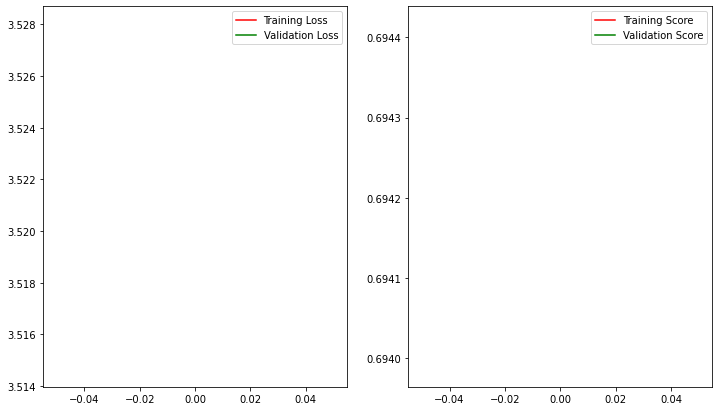

Iteration : 1


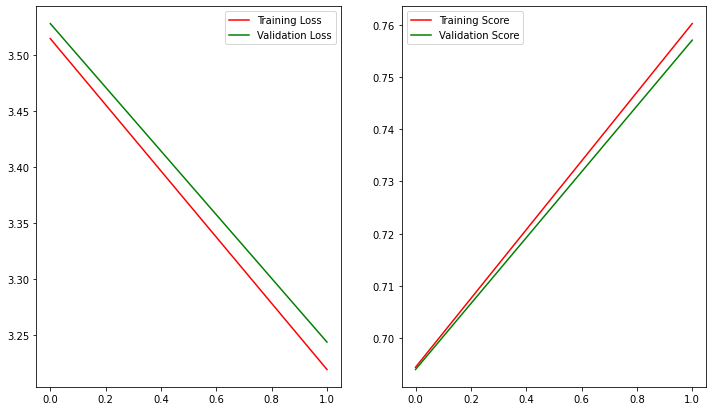

Iteration : 2


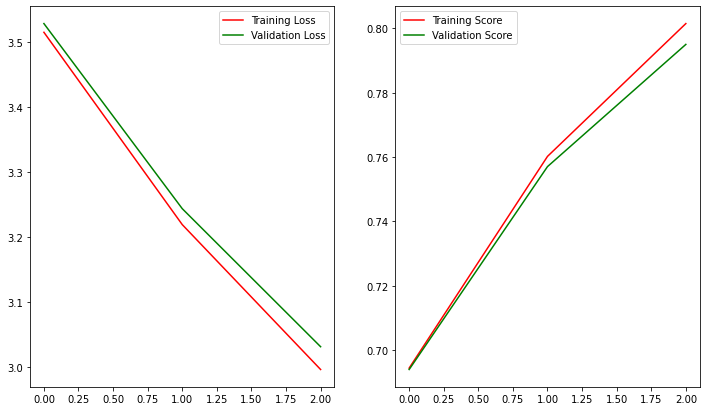

Iteration : 3


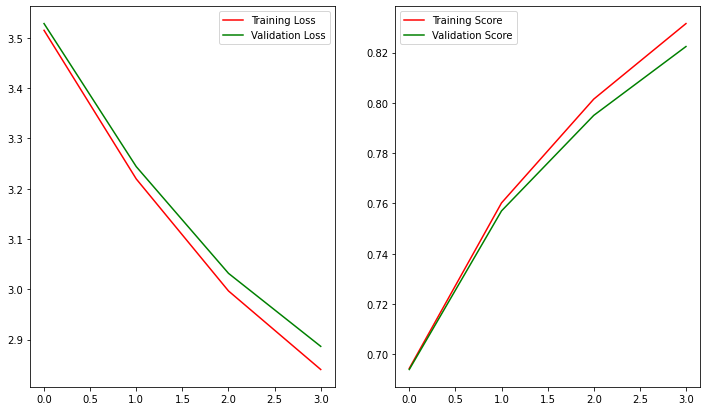

Iteration : 4


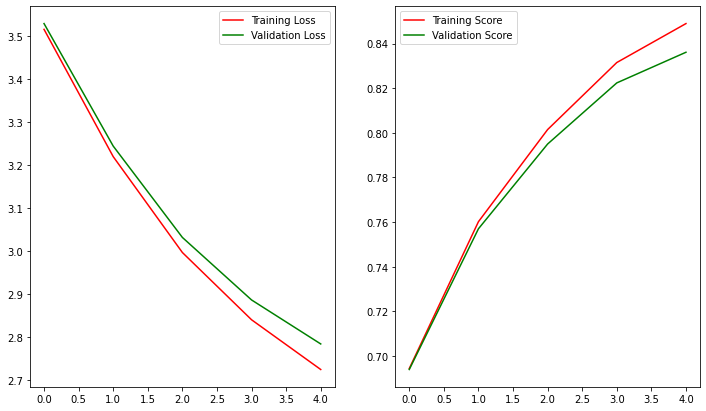

Iteration : 5


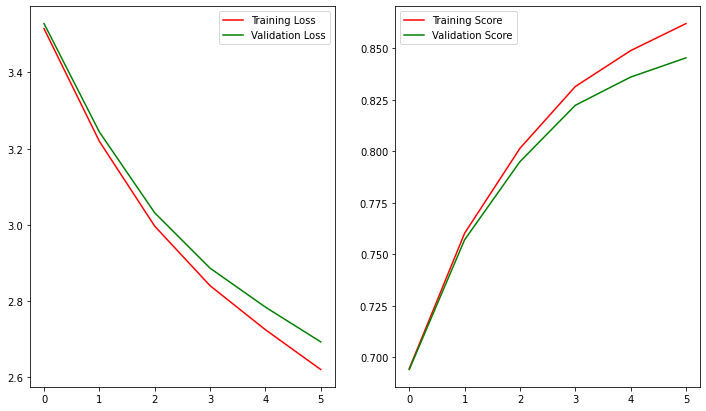

Iteration : 6


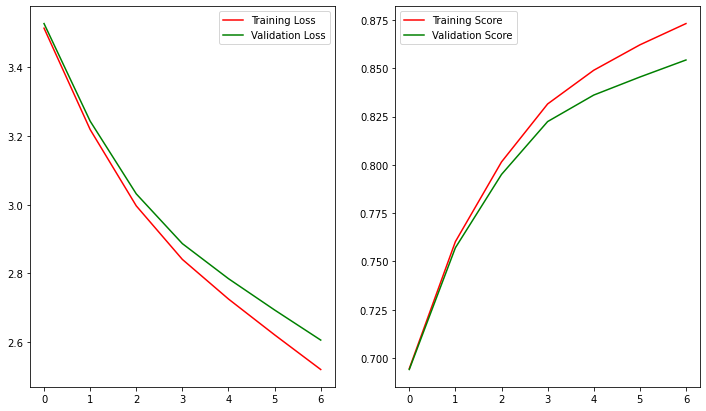

Iteration : 7


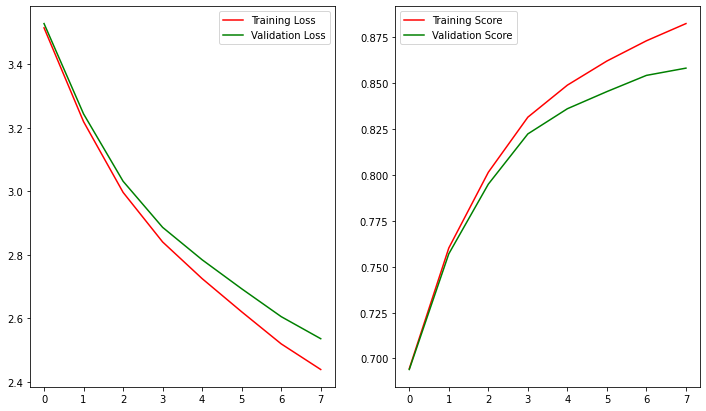

Iteration : 8


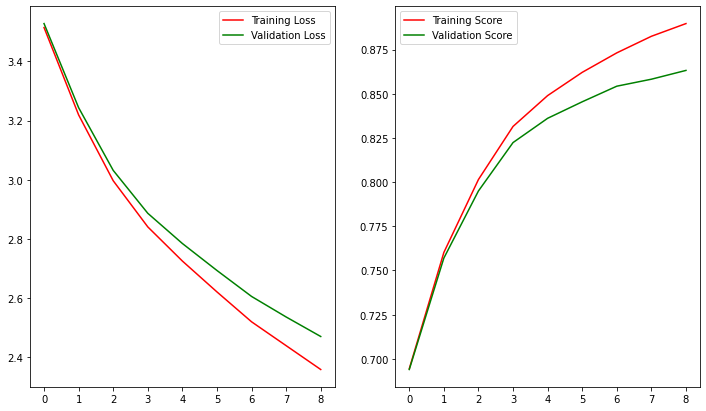

Iteration : 9


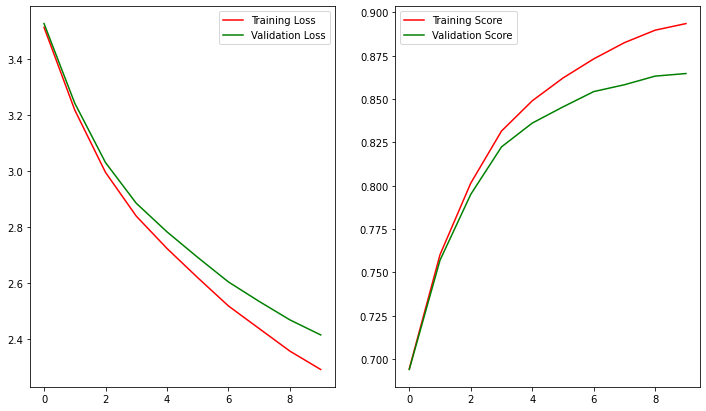

Iteration : 10


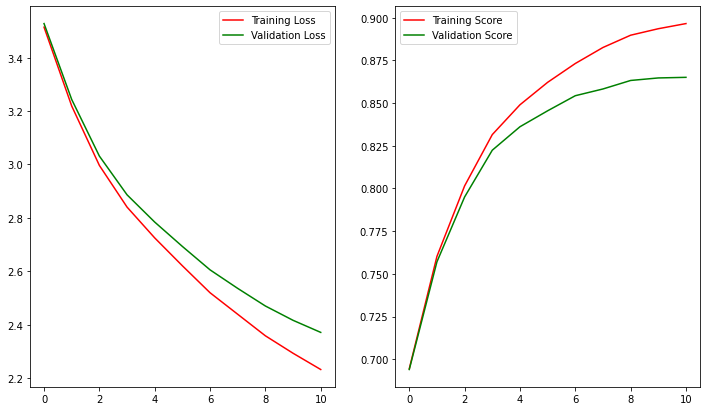

Iteration : 11


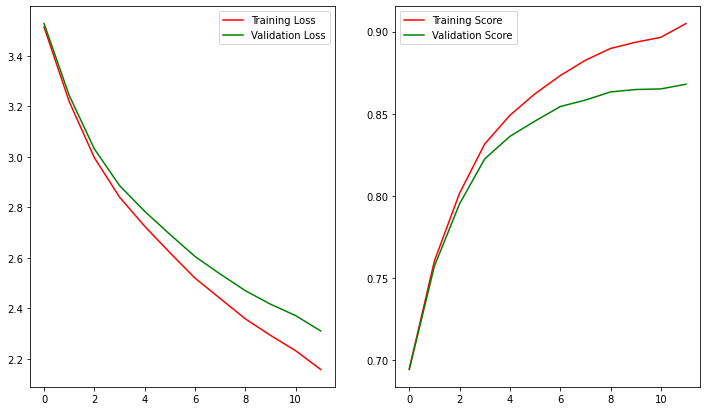

Iteration : 12


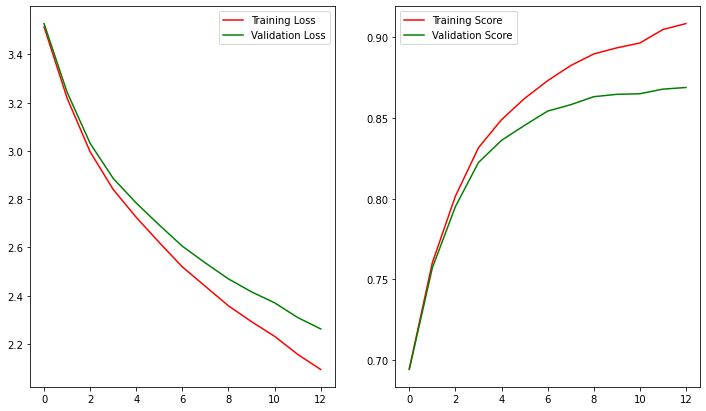

Iteration : 13


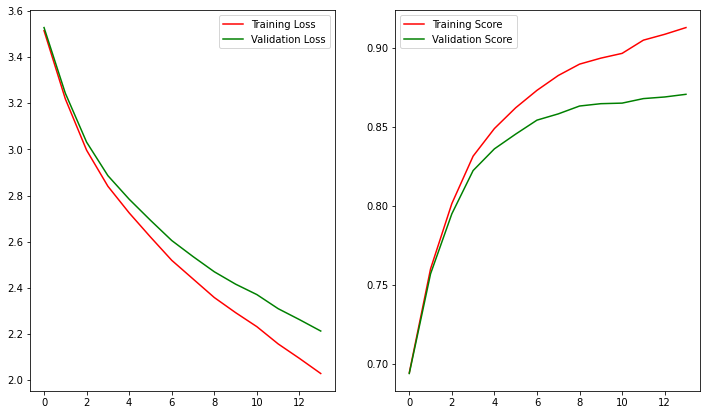

Iteration : 14


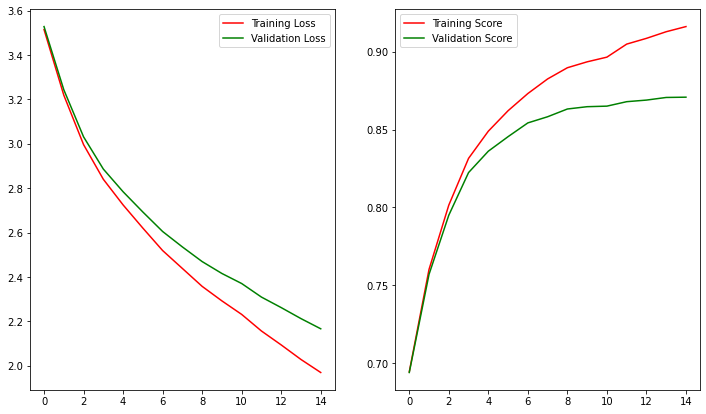

Iteration : 15


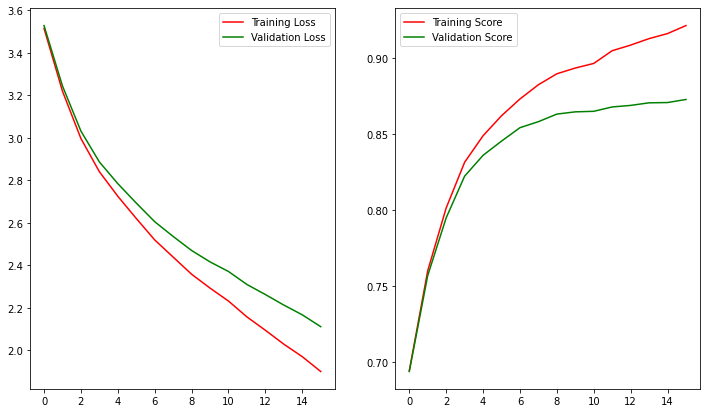

In [29]:
trainer = train_model(train_loader,
                      test_loader,
                      'clf',
                      model,
                      optimizer,
                      loss_func,
                      16)
model, h = trainer.train_it()

# Evaluating

In [30]:
model.eval()

myencdec(
  (enc): encoder(
    (emb): Embedding(59, 50)
    (rnn): LSTM(50, 200, num_layers=2, batch_first=True, dropout=0.2)
  )
  (dec): decoder(
    (emb): Embedding(82, 50)
    (rnn): LSTM(50, 200, num_layers=2, batch_first=True, dropout=0.2)
    (fc): Linear(in_features=200, out_features=82, bias=True)
  )
)

In [31]:
for X in test_loader:
    out =model(X)
    break

In [32]:
for idx in list(np.arange(127)):
  inv_dict = dict(zip(d_output.values(), d_output.keys()))
  print(''.join([inv_dict[j.item()] for j in torch.argmax(out[idx],axis=1)]))
  print(''.join([inv_dict[j.item()] for j in X[2][idx]]))
  print('==============================================')

फोर्ट<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
फोर्ट<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
<PAD>ंडिगा<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
चंडीगढ़<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
एमेरिकन<EOS><PAD><PAD><PAD><PAD><PAD><PAD>
अमेरिकन<EOS><PAD><PAD><PAD><PAD><PAD><PAD>
एेकक्सार्सा<EOS>स<EOS>
हेडक्वार्टर्स<EOS>
फाीिकर<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
फलणीकर<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
नीममिी<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
नीलमणि<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
महमूह<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
महमूद<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
डैम<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
डैम<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
साहिबा<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
साहिब<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
ऑम्ब्ब्न्ग<EOS><EOS><PAD><PAD>
अम्बेडकरनगर<EOS><PAD><PAD>
सिकककियमम<PAD><PAD><PAD><PAD><PAD>
सिस्कियो<EOS><PAD><PAD><PAD><PAD><PAD>
बेबा<EOS><PAD><PAD><PAD><PAD><PAD>

# Testing

In [52]:
fortest = mydata(['train'],['1111111111111'])
fortestload = DataLoader(fortest,1,collate_fn=padder)
h0 = torch.randn((enc.layers,128,enc.hidden_size))
c0 = torch.randn((enc.layers,128,enc.hidden_size))
for X in fortestload:
  h0 = torch.randn((enc.layers,128,enc.hidden_size))
  c0 = torch.randn((enc.layers,128,enc.hidden_size))

  h0,c0 = model.enc(X[0],X[3],h0,c0)
  o,h1,c1 = model.dec(X[1][0][0].reshape(-1,1),[1],h0,c0)
  
  id = torch.argmax(o)
  s = inv_dict[torch.argmax(o).item()]
  for i in range(100):
    if id.item()!=2:
      o,h1,c1 = model.dec(id.reshape(-1,1),[1],h1,c1)
      id = torch.argmax(o)
      s = s + inv_dict[torch.argmax(o).item()]
  print(s)

ट्रेन<EOS>
